In [1]:
import torch
from snn_delays.snn import SNN
from snn_delays.experimental_models.snn_binary import TH_BinarySNN, BinarySNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.train_utils import train, get_device, propagate_batch
from snn_delays.utils.visualization_utils import plot_raster
from snn_delays.utils.test_behavior import tb_save_max_last_acc
import matplotlib.pyplot as plt

device = get_device()

# For reproducibility
torch.manual_seed(10)

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


## Load dataset

In [2]:
### DATASET

# Parameters
dataset = 'nmnist'
total_time = 50
batch_size = 1024

# Resized dataloader
# DATASET
DL = DatasetLoader(dataset=dataset,
                   caching='gpu',
                   num_workers=0,
                   batch_size=batch_size,
                   total_time=total_time, 
                   sensor_size_to=17)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

[Downsample(time_factor=1, spatial_factor=0.5, sensor_size=None, target_size=None), ToFrame(sensor_size=(17, 17, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]
<class 'list'>


### Loading, testing best performing binary model, weight visualization


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
1
Delta t: 0.02 ms
mean of normal: 6.907255237315501
Instance of <class 'snn_delays.experimental_models.snn_binary.BinarySNN'> loaded successfully
Test Loss: 0.2962014973163605
Avg spk_count per neuron for all 50 time-steps 19.814956665039062
Avg spk per neuron per layer [19.814956665039062]
Test Accuracy of the model on the test samples: 91.699


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
1
Delta t: 0.02 ms
mean of normal: 6.907255237315501
tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5724, device='cuda:0', grad_fn=<MeanBackward0>)


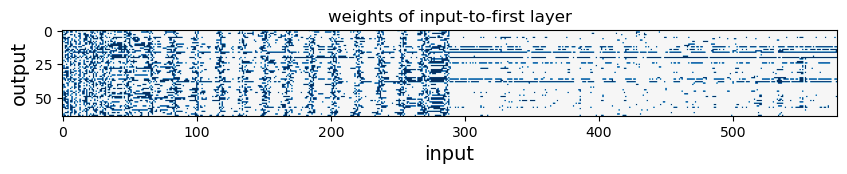

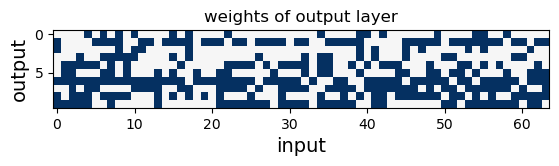

Test Loss: 0.27046751976013184
Avg spk_count per neuron for all 50 time-steps 19.5240478515625
Avg spk per neuron per layer [19.5240478515625]
Test Accuracy of the model on the test samples: 91.992



In [ ]:
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.visualization_utils import plot_param

model_name = 'binary_nmnist50_l1_1d1.t7_9232_max_56epoch'
ckpt_dir = 'exp_snn2chip_nmnist'
snn = ModelLoader(model_name, ckpt_dir, 1024, 'cuda', True)

# snn_test = copy_snn(snn, batch_size)
# snn_test.debug = True
aa, bb = snn.test(test_loader, only_one_batch=True)

### Creating a SNN copy of the BinarySNN 
structure = (64, 1)
dataset_dict["time_ms"] = 1
loss_fn = 'mem_sum'
binary_mode ='binary'

snn_test = SNN(dataset_dict=dataset_dict, structure=structure, connection_type='f',
          delay=None, delay_type='', tau_m='normal',
          reset_to_zero=True, win=total_time,
          loss_fn=loss_fn, batch_size=batch_size, device=device,
          debug=True)
snn_test.set_network()

weight_taus = [(name, w) for name, w  in snn_test.named_parameters() if 'th' not in name]
for (name_src, param_src), (name_dst, param_dst) in zip(snn.named_parameters(), weight_taus):
    assert name_src == name_dst, f"Parameter mismatch: {name_src} != {name_dst}"
    param_dst.data.copy_(param_src.data)

w_params = [w for name, w  in snn_test.named_parameters() if 'f' in name]

for w in w_params:
    scale = w.abs().mean()
    print(scale)
    if binary_mode == 'binary':
        w.data = (w.data > 0.0).float().mul(scale).mul(0.3)
    #w.data = (w.data > 0.0).float().mul(scale)
    elif binary_mode == 'sign':
        w.data = w.data.mul(scale).sign().mul(scale)
    elif binary_mode == 'relu':
        w.data = w.data.clamp(0, 1).mul(scale)
        #w.data = w.data
    #w.data = (w.data > 0.0).float().mul(scale*0.3)

plt.figure(figsize=(10,10))

plot_param(w_params[0], '2D')
plt.title('weights of input-to-first layer')
plt.show()

plot_param(w_params[1], '2D')
plt.title('weights of output layer')
plt.show()

a, b =snn_test.test(test_loader, only_one_batch=True)

## Evolution of spikes and membrane potentials

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Text(0.5, 1.0, 'first layer spikes')

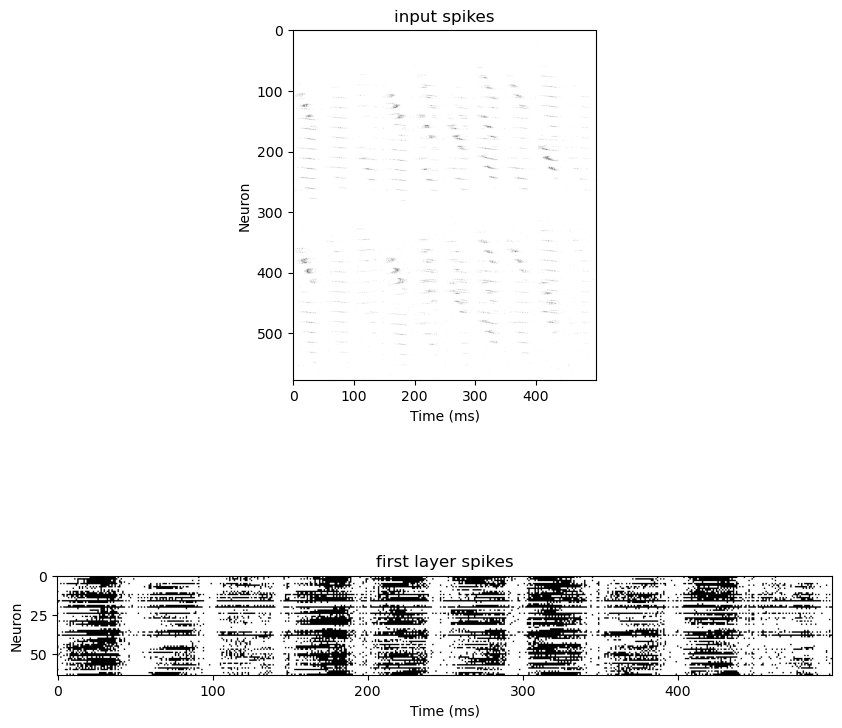

In [9]:
from snn_delays.utils.visualization_utils import plot_raster
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('input spikes')
plot_raster(snn, 'input', 10)
plt.subplot(212)
plot_raster(snn, 'f1', 10)
plt.title('first layer spikes')

Extraction of spikes and membranes

In [11]:
spk_input = snn.spike_state['input']
spk_f1= snn.spike_state['f1']
mem_f1 = snn.mem_state['f1']
mem_output = snn.mem_state['output']

plotting membrane potentials of 10 samples

In [12]:
mems_out = mem_output[:, :10, :].permute(1, 0, 2).reshape(500, 10)

Text(0.5, 1.0, 'membrane potentials')

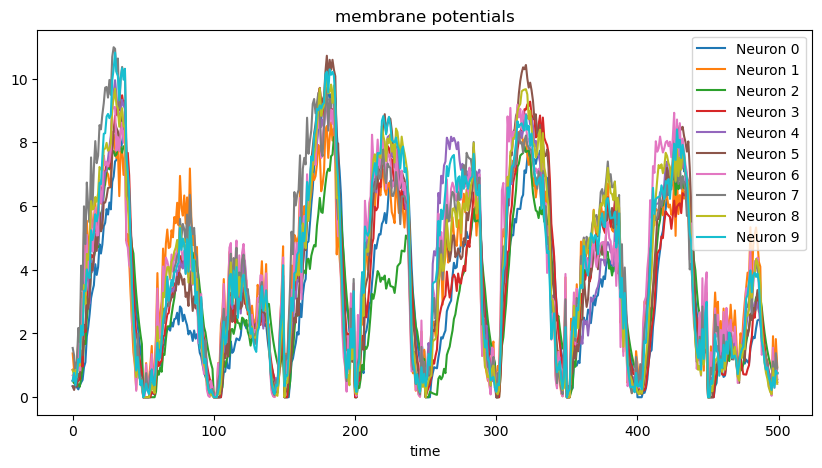

In [13]:
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(mems_out.cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
    plt.legend()
plt.xlabel('time')
plt.title('membrane potentials')

Text(0.5, 1.0, 'softmax of membrane potentials')

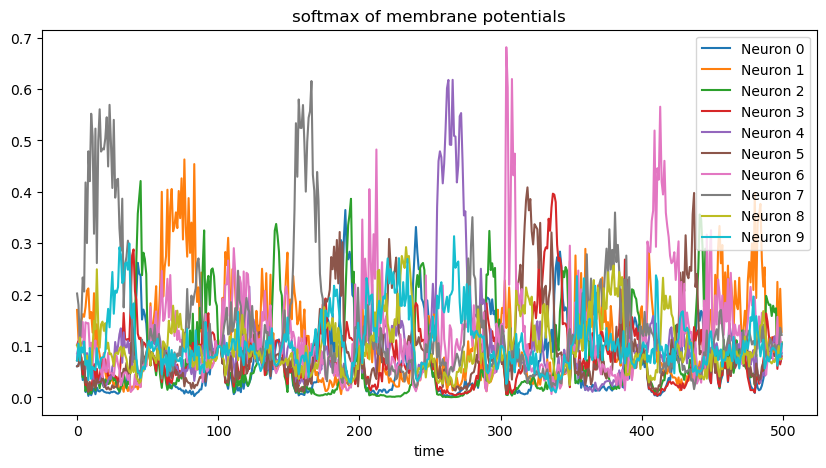

In [14]:
import torch.nn.functional as F
soft_mems = F.softmax(snn.mem_state['output'][:, :10, :], dim=2).permute(1, 0, 2).reshape(500, 10)
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(soft_mems.detach().cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
    plt.legend()
plt.xlabel('time')
plt.title('softmax of membrane potentials')

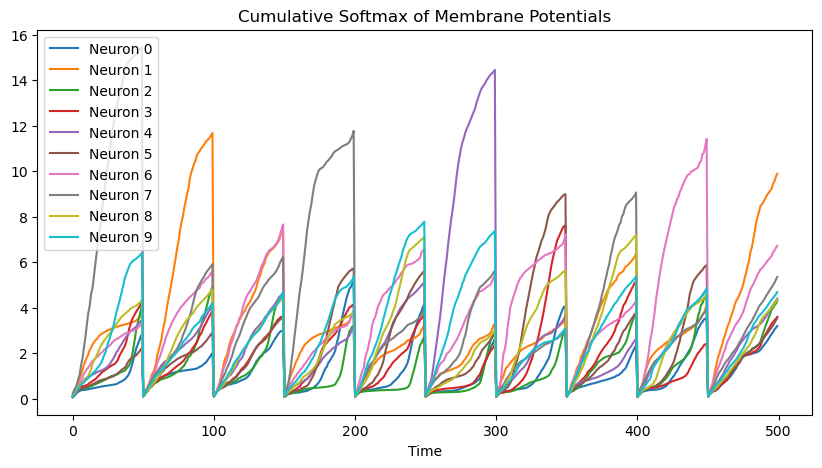

In [15]:
# Apply softmax to the first 10 neurons' membrane potentials
soft_mems = F.softmax(snn.mem_state['output'][:, :10, :], dim=2)
soft_mems_cumulative = torch.cumsum(soft_mems, dim=0)
soft_mems_cumulative = soft_mems_cumulative.permute(1, 0, 2).reshape(500, 10)

# Plot the cumulative softmax membrane potentials
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(soft_mems_cumulative.detach().cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
plt.legend()
plt.xlabel('Time')
plt.title('Cumulative Softmax of Membrane Potentials')
plt.show()

references and predictions

In [16]:
print(f'references:{aa[:10]}, predictions: {bb[:10]}')

references:[7, 1, 1, 7, 8, 4, 5, 7, 6, 1], predictions: [7, 1, 6, 7, 9, 4, 5, 7, 6, 1]
